# Toxicidad

In [ ]:
#Referencias:
#https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
#https://seaborn.pydata.org/generated/seaborn.pairplot.html
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [16]:
#!pip install wordcloud

In [1]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from wordcloud import WordCloud

In [25]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

In [3]:
#Exploración de datos:
dftrain = pd.read_csv('datos/jigsaw-unintended-bias-train.csv') 
dftrain.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
#Revisamos las variables 
dftrain.count()

id                                     1902194
comment_text                           1902194
toxic                                  1902194
severe_toxicity                        1902194
obscene                                1902194
identity_attack                        1902194
insult                                 1902194
threat                                 1902194
asian                                   426707
atheist                                 426707
bisexual                                426707
black                                   426707
buddhist                                426707
christian                               426707
female                                  426707
heterosexual                            426707
hindu                                   426707
homosexual_gay_or_lesbian               426707
intellectual_or_learning_disability     426707
jewish                                  426707
latino                                  426707
male         

In [5]:
#Seleccionamos las variables que nos interesan
col = ['comment_text','toxic','severe_toxicity','obscene','identity_attack','insult','threat']
dftrain = dftrain[col]
dftrain = dftrain[pd.notnull(dftrain['comment_text'])]
dftrain.head()

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0


In [6]:
#Describimos las variables que nos interesan
dftrain.describe()

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
count,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06
mean,1.030068e-01,4.585531e-03,1.388516e-02,2.259572e-02,8.117227e-02,9.298498e-03
std,1.970813e-01,2.286902e-02,6.465998e-02,7.863447e-02,1.760987e-01,4.939469e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


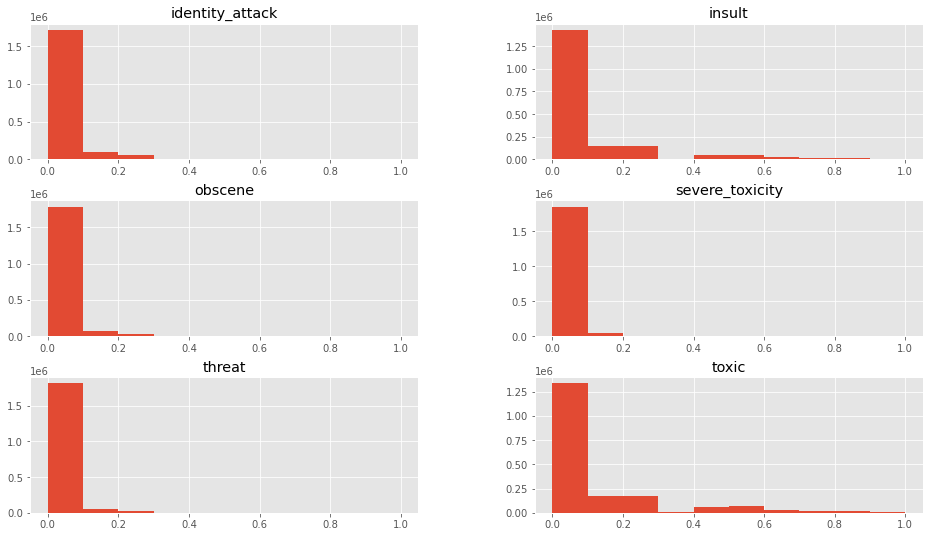

In [7]:
#Veamos graficamente los datos para tener una idea de la dispersión de los mismos
dftrain.hist()
plt.show()

In [8]:
#Calculamos el grado de toxicidad para ver la distribución de los comentarios toxicos
dftrain['toxicidad'] = dftrain['toxic'].round(1).factorize(sort=True)[0]
toxicidad_id_df = dftrain[['toxic', 'toxicidad']].drop_duplicates().sort_values('toxicidad')
toxicidad_to_id = dict(toxicidad_id_df.values)
id_to_category = dict(toxicidad_id_df[['toxicidad', 'toxic']].values)
dftrain.head()

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,9


In [9]:
#Comentarios mas tóxicos
dftrain.loc[dftrain.toxicidad == 10]

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
289,You're an idiot.,0.968750,0.031250,0.062500,0.000000,0.968750,0.000000,10
714,Where do you get the Sour Grapes to say this i...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,10
767,Dear world:\nJust a reminder that none of thes...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
2521,F u c k the homeless. The people giving handou...,0.973006,0.261350,0.942331,0.118405,0.722086,0.719018,10
2551,The Liars Anonymous meeting today will be at 4...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
...,...,...,...,...,...,...,...,...
1900532,Trudeau speaks out of both sides of his face. ...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
1901502,Any destruction of Alaska's Grand Nature by th...,1.000000,0.200000,0.000000,0.000000,1.000000,0.000000,10
1901605,And if an employee cannot live on the offered ...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
1902098,Good lord it looks like mr. zipper plat is bei...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10


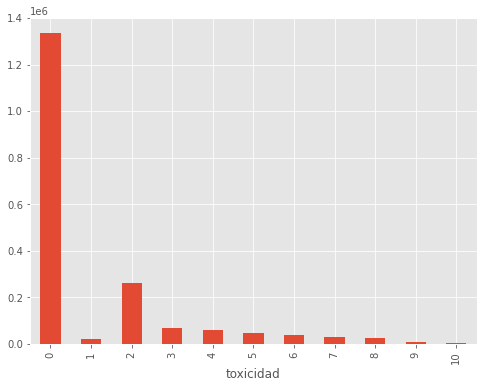

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dftrain.groupby('toxicidad').comment_text.count().plot.bar(ylim=0)
plt.show()

In [11]:
dftrain.groupby('toxicidad').comment_text.count()

toxicidad
0     1333804
1       22935
2      262812
3       67112
4       59536
5       48428
6       38387
7       28707
8       25765
9        9359
10       5349
Name: comment_text, dtype: int64

c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0

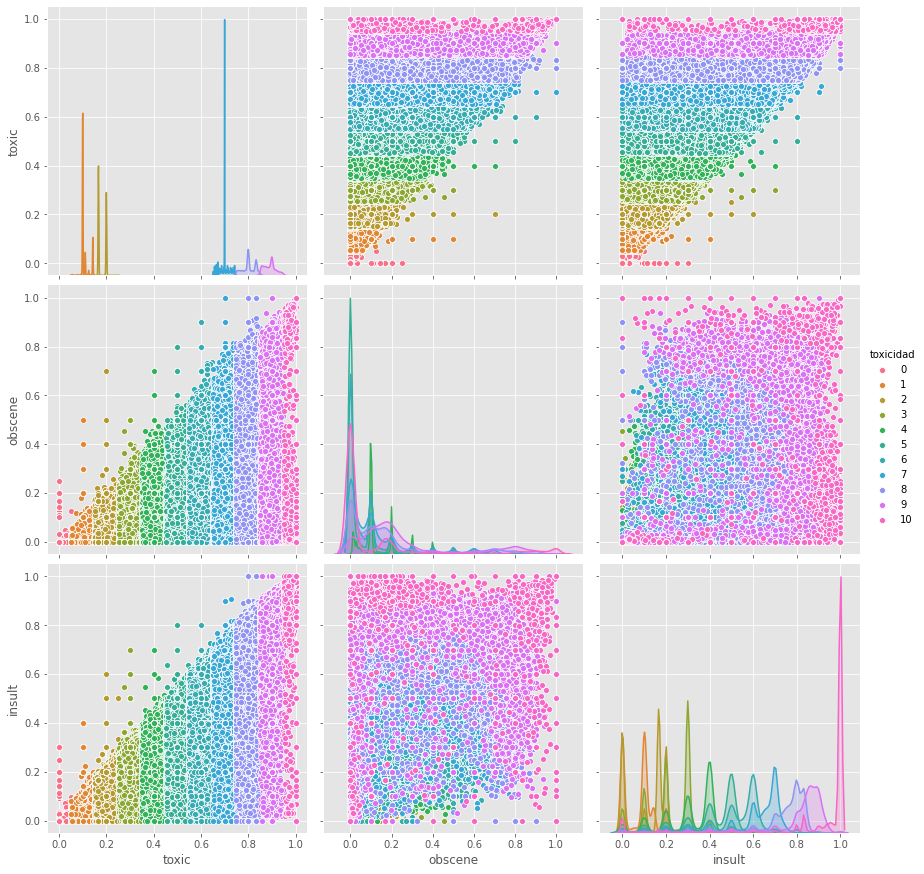

In [12]:
sb.pairplot(dftrain.dropna(), hue='toxicidad',height=4,vars=["toxic","obscene","insult"],kind='scatter')

In [13]:
#Revision de comentarios mas tóxicos
dftoxico = dftrain.loc[dftrain.toxicidad == 10]
dftoxico.comment_text

289                                         You're an idiot.
714        Where do you get the Sour Grapes to say this i...
767        Dear world:\nJust a reminder that none of thes...
2521       F u c k the homeless. The people giving handou...
2551       The Liars Anonymous meeting today will be at 4...
                                 ...                        
1900532    Trudeau speaks out of both sides of his face. ...
1901502    Any destruction of Alaska's Grand Nature by th...
1901605    And if an employee cannot live on the offered ...
1902098    Good lord it looks like mr. zipper plat is bei...
1902179    Well the Dumper Post has a Indian idiot writin...
Name: comment_text, Length: 5349, dtype: object

(-0.5, 399.5, 199.5, -0.5)

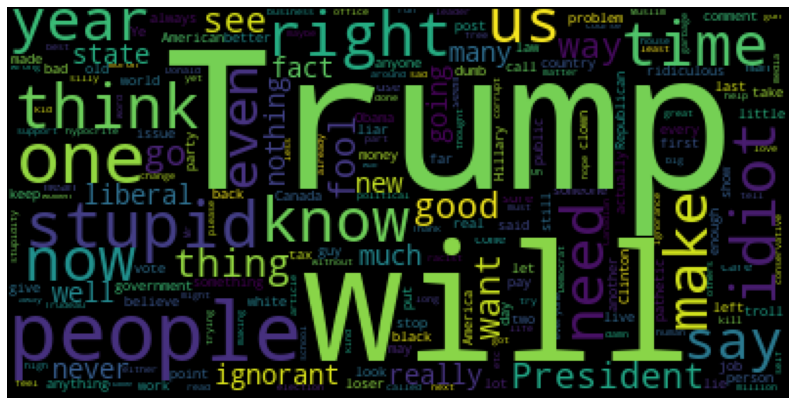

In [27]:
#Revisar las palabras que mas aparecen en los comentarios más tóxicos
#Codigo adaptado de https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models 
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

# Generar la word cloud 
text = ' '.join([nonan(comentario) for comentario in dftoxico["comment_text"]])
wordcloud = WordCloud(max_font_size=None, collocations=False).generate(text)

# Visualizar la wordcloud 
plt.imshow(wordcloud)
plt.axis("off")

### Se crea la instancia de kmeans y se tiene que fijar el número de cluster usando "n_cluster"

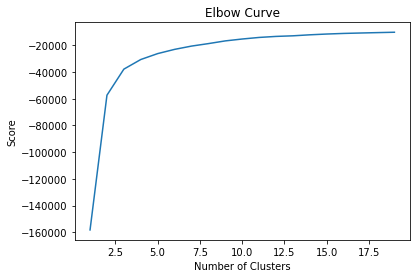

In [17]:
#Revisamos el k óptimo
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train = dftrain[col]

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#### Vemos que mas o menos en 3 está el punto de quiebre

In [15]:
#Realizamos una clusterización con k-medias = 3 para saber posibles agrupaciones
n_clusters = 3
clustering = cluster.KMeans(n_clusters=n_clusters)

In [16]:
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train = dftrain[col]
X_train

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.893617,0.021277,0.0,0.021277,0.872340,0.0
...,...,...,...,...,...,...
1902189,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1902190,0.166667,0.000000,0.0,0.166667,0.166667,0.0
1902191,0.400000,0.000000,0.0,0.100000,0.400000,0.0
1902192,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [17]:
clustering.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
y_pred = clustering.predict(X_train)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

El resultado es un array de enteros de la misma logitud del número de muestras en el dataset de entrenamiento.

Los elementos en el array indican a cual grupo pertenece desde 0 hasta (tamañoDeLaMuestra-1)

In [19]:
#Escribimos el resultado en el dataset de entrenamiento
X_train['toxicidad'] = y_pred
X_train

c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
4,0.893617,0.021277,0.0,0.021277,0.872340,0.0,2
...,...,...,...,...,...,...,...
1902189,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
1902190,0.166667,0.000000,0.0,0.166667,0.166667,0.0,1
1902191,0.400000,0.000000,0.0,0.100000,0.400000,0.0,1
1902192,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0


In [20]:
#Ver cantidades por clase
print(X_train.groupby('toxicidad').size())

toxicidad
0    1415377
1     345534
2     141283
dtype: int64


In [21]:
X_clase1 = X_train[ X_train['toxicidad']==0 ][['toxic','severe_toxicity']]
X_clase2 = X_train[ X_train['toxicidad']==1 ][['toxic','severe_toxicity']]
X_clase3 = X_train[ X_train['toxicidad']==2 ][['toxic','severe_toxicity']]

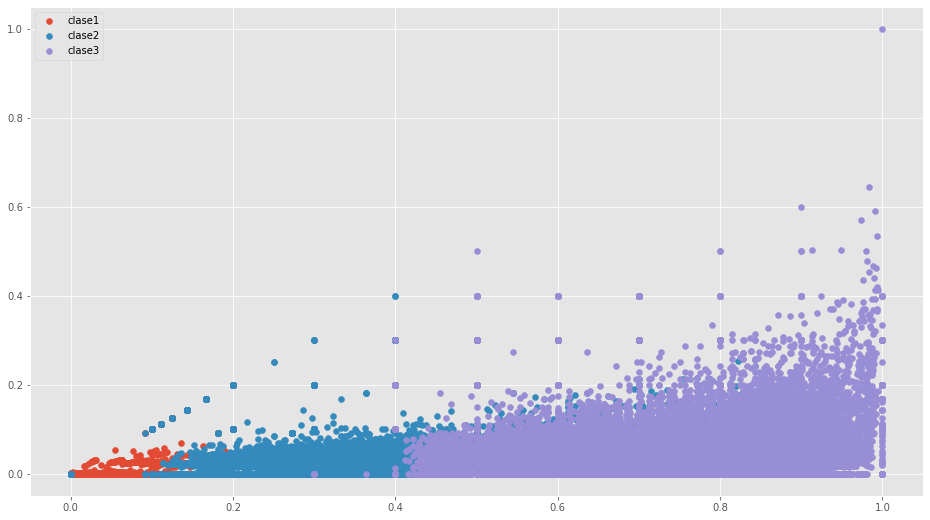

In [22]:
plt.scatter(X_clase1['toxic'], X_clase1['severe_toxicity'])
plt.scatter(X_clase2['toxic'], X_clase2['severe_toxicity'])
plt.scatter(X_clase3['toxic'], X_clase3['severe_toxicity'])
plt.legend(('clase1', 'clase2', 'clase3'))

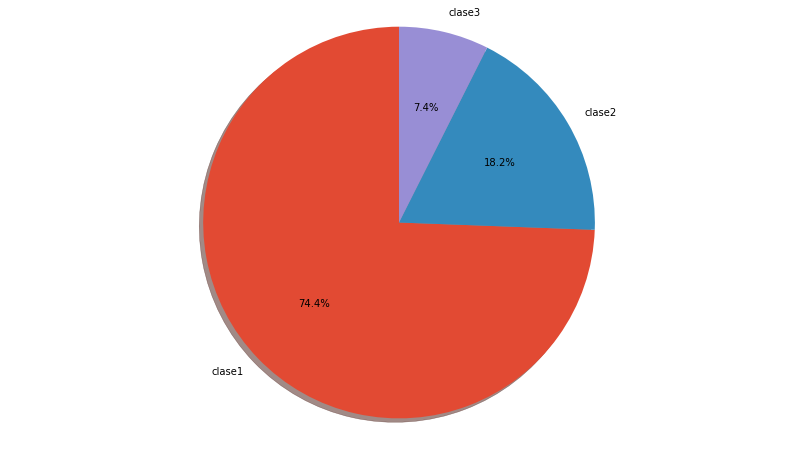

In [26]:
#Distribución de las clases
labels = 'clase1', 'clase2', 'clase3'
sizes = X_train.groupby('toxicidad').size().values
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [48]:
centers = clustering.cluster_centers_
centers = pd.DataFrame(centers)
centers.columns = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
centers

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,0.009221,0.000500,0.001369,0.003360,0.001679,0.002798
1,0.258510,0.011057,0.023075,0.069973,0.195626,0.027169
2,0.662360,0.029695,0.116823,0.099441,0.597736,0.030723


In [49]:
centers = centers.transpose()
centers.columns = ['Clase 1','Clase 2','Clase 3']
centers

,Clase 1,Clase 2,Clase 3
toxic,0.009221,0.258510,0.662360
severe_toxicity,0.000500,0.011057,0.029695
obscene,0.001369,0.023075,0.116823
identity_attack,0.003360,0.069973,0.099441
insult,0.001679,0.195626,0.597736
threat,0.002798,0.027169,0.030723


In [33]:

X = np.array(X)
y = y_pred
fig, axes = plt.subplots(N, N, figsize=(12, 12), sharex=True,sharey=True)
colors = ["coral", "blue", "green"]
markers = ["^", "v", "o"]
for m in range(N):
    for n in range(N):
        for p in range(n_clusters):
            mask = y_pred == p
            axes[m, n].scatter(X[:, m][mask], X[:, n][mask], s=30,marker=markers[p], color=colors[p],alpha=0.25)
        for idx in np.where(y != y_pred):
            axes[m, n].scatter(X[idx, m], X[idx, n], s=30,marker="s", edgecolor="red", facecolor=(1,1,1,0))
            axes[N-1, m].set_xlabel(col[m], fontsize=16)
            axes[m, 0].set_ylabel(col[m], fontsize=16)

array([[9.22137814e-03, 4.99881904e-04, 1.36876031e-03, 3.36029013e-03,
        1.67855346e-03, 2.79771609e-03],
       [2.58510232e-01, 1.10566003e-02, 2.30750105e-02, 6.99732765e-02,
        1.95626380e-01, 2.71685774e-02],
       [6.62359765e-01, 2.96949004e-02, 1.16822669e-01, 9.94410096e-02,
        5.97736491e-01, 3.07227750e-02]])

In [ ]:
#Reseteamos el set de datos
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train = dftrain[col]
X_train

In [22]:
#Realizamos una clusterización con k-medias = 5 para saber posibles agrupaciones
n_clusters = 5
clustering = cluster.KMeans(n_clusters=n_clusters)
clustering.fit(X_train)
y_pred = clustering.predict(X_train)
X_train['toxicidad'] = y_pred

c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


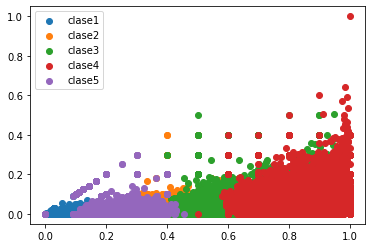

In [23]:
X_clase1 = X_train[ X_train['toxicidad']==0 ][['toxic','severe_toxicity']]
X_clase2 = X_train[ X_train['toxicidad']==1 ][['toxic','severe_toxicity']]
X_clase3 = X_train[ X_train['toxicidad']==2 ][['toxic','severe_toxicity']]
X_clase4 = X_train[ X_train['toxicidad']==3 ][['toxic','severe_toxicity']]
X_clase5 = X_train[ X_train['toxicidad']==4 ][['toxic','severe_toxicity']]

plt.scatter(X_clase1['toxic'], X_clase1['severe_toxicity'])
plt.scatter(X_clase2['toxic'], X_clase2['severe_toxicity'])
plt.scatter(X_clase3['toxic'], X_clase3['severe_toxicity'])
plt.scatter(X_clase4['toxic'], X_clase4['severe_toxicity'])
plt.scatter(X_clase5['toxic'], X_clase5['severe_toxicity'])
plt.legend(('clase1', 'clase2', 'clase3', 'clase4', 'clase5'))

In [55]:
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X = dftrain[col]

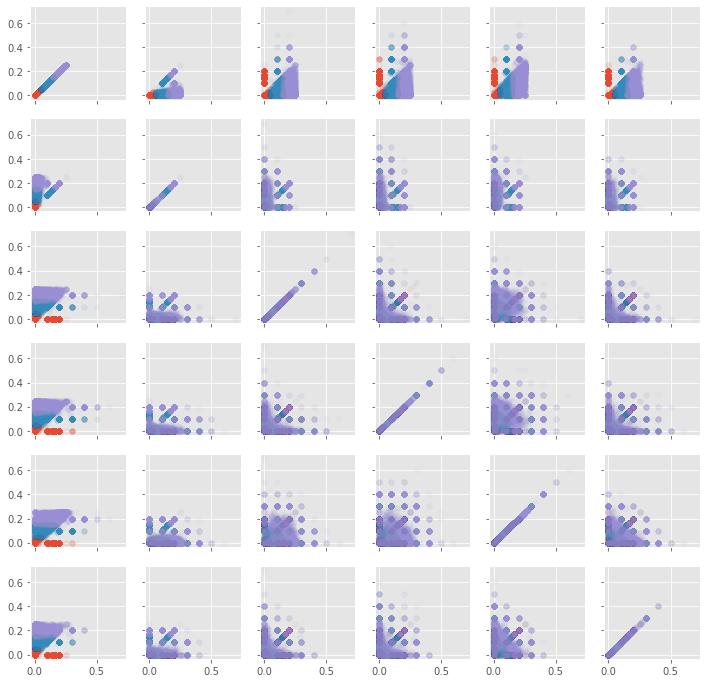

In [56]:
#Visualicemos como se distribuyen las clases en las distintas variables
N = X.shape[1]
X = np.array(X)
y = dftrain['toxicidad']
fig, axes = plt.subplots(N, N, figsize=(15, 15), sharex=True,sharey=True)

for m in range(N):
    for n in range(N):
        for p in range(n_clusters):
            mask = y == p
            axes[m, n].scatter(X[:, m][mask], X[:, n][mask], s=30, alpha=0.05)


c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0

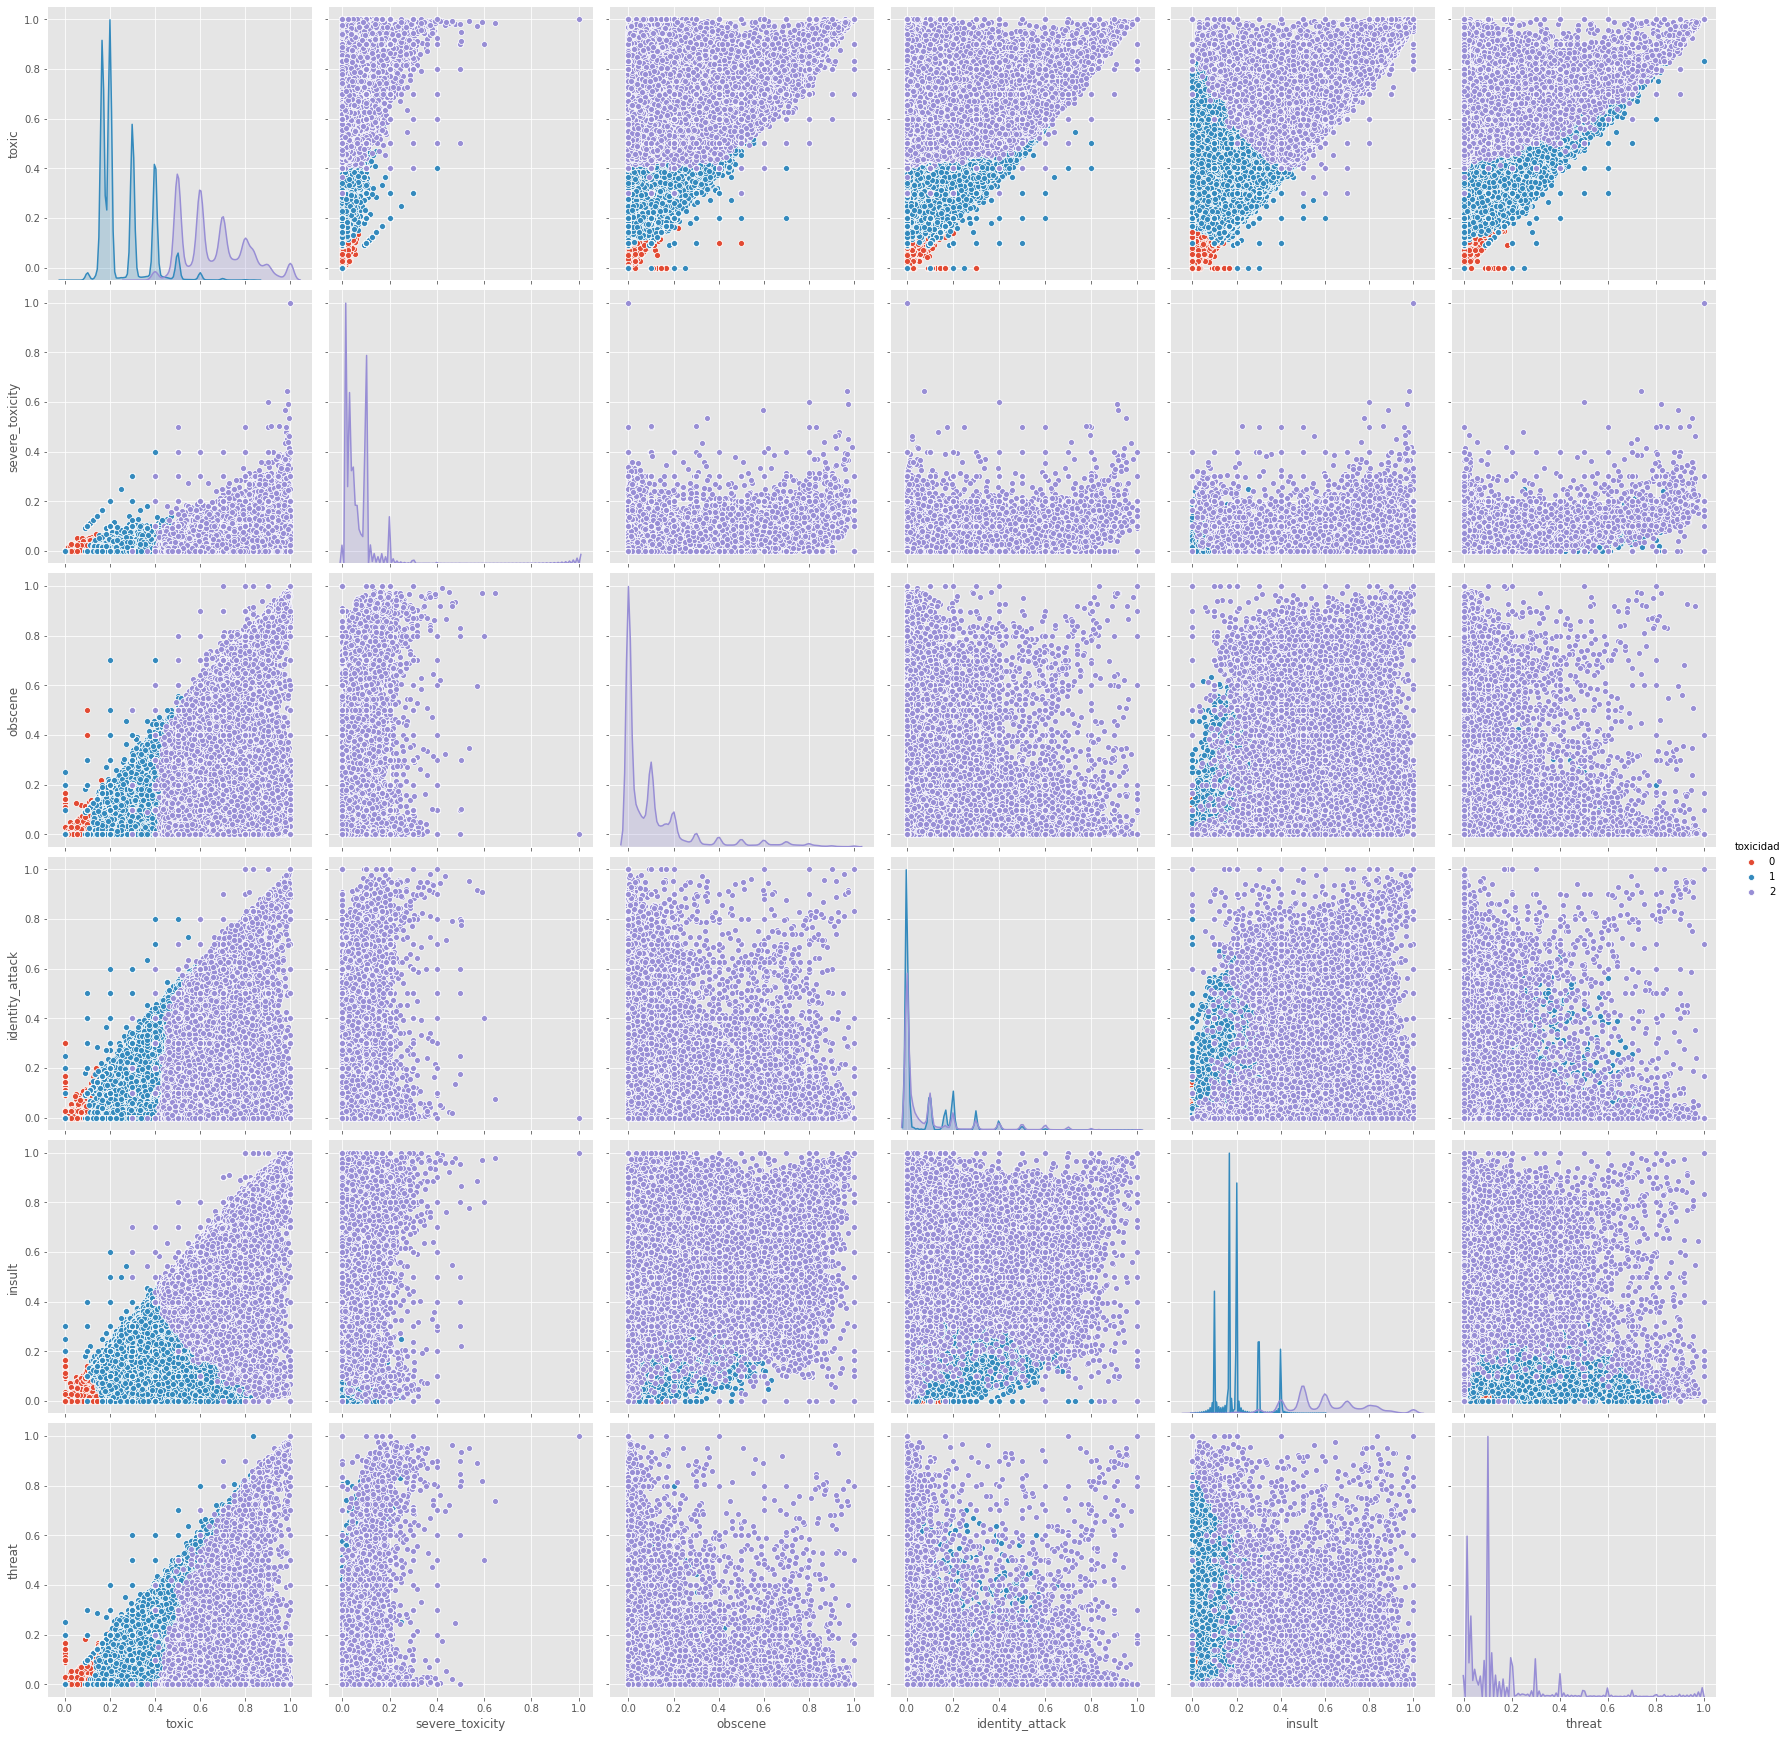

In [57]:
#Visualizamos la relación de las variables con respecto a la toxicidad predicha
sb.pairplot(X_train.dropna(),hue='toxicidad', height=4,vars=['toxic','severe_toxicity','obscene','identity_attack','insult','threat'],kind='scatter')

In [ ]:
y, X = patsy.dmatrices("y ~   x1 + x2 + x1**2 + x1*x2 + x2**2", df)
logmodel = sm.Logit(y, X)
logresult = logmodel.fit()
logresult.summary()